# DATA FILTERING

In [3]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/home/venkatesh/Desktop/ml/clustering_data.csv', low_memory=False)

# Filter the data to only include rows where the StateName is 'MAHARASHTRA'
maharashtra_data = df[df['StateName'].str.upper() == 'MAHARASHTRA'].copy()

print(maharashtra_data)

                CircleName         RegionName         DivisionName  \
934     Maharashtra Circle      Nagpur Region   Amaravati Division   
37630   Maharashtra Circle      Nagpur Region  Chandrapur Division   
37631   Maharashtra Circle      Nagpur Region  Chandrapur Division   
37632   Maharashtra Circle      Nagpur Region  Chandrapur Division   
38709   Maharashtra Circle  Aurangabad Region   Osmanabad Division   
...                    ...                ...                  ...   
156817  Maharashtra Circle      Nagpur Region  Chandrapur Division   
156818  Maharashtra Circle      Nagpur Region  Chandrapur Division   
156819  Maharashtra Circle      Nagpur Region  Chandrapur Division   
156820  Maharashtra Circle      Nagpur Region  Chandrapur Division   
156914  Maharashtra Circle  Goa-Panaji Region    Kolhapur Division   

                       OfficeName  Pincode OfficeType      Delivery  \
934                  Bhatkuli S.O   444602         PO  Non Delivery   
37630            

In [9]:
##### filtering of points that are outside maharashtra by using geopandas


import folium
from folium.plugins import MarkerCluster
import geopandas as gpd
from shapely.geometry import Point

# Load the Maharashtra boundaries from a GeoJSON file
maharashtra_geojson = gpd.read_file('export.geojson')

# Create a GeoDataFrame from the filtered data
geometry = [Point(xy) for xy in zip(maharashtra_data['Longitude'], maharashtra_data['Latitude'])]
maharashtra_points = gpd.GeoDataFrame(maharashtra_data, geometry=geometry, crs="EPSG:4326")

# Perform a spatial join to filter points within Maharashtra
maharashtra_points = gpd.sjoin(maharashtra_points, maharashtra_geojson, how="inner", predicate='within')



## DATA VISUALIZATION

In [10]:
# Initialize a map centered around an average location in Maharashtra
map_center = [maharashtra_points['Latitude'].mean(), maharashtra_points['Longitude'].mean()]
map = folium.Map(location=map_center, zoom_start=7)

# Use MarkerCluster to group close markers together
marker_cluster = MarkerCluster().add_to(map)

# Add markers to the map
for idx, row in maharashtra_points.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"Pincode: {row['Pincode']}",
    ).add_to(marker_cluster)

# Save the map to an HTML file and open it in the browser
map_file = 'maharashtra_map.html'
map.save(map_file)
webbrowser.open(map_file)

True

### CLUSTERING ANALYSIS

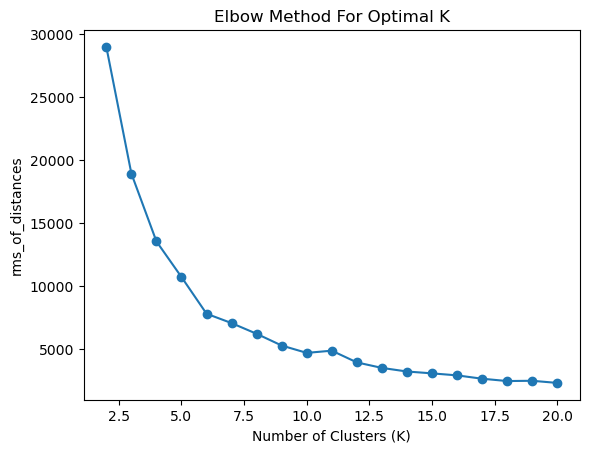

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the Latitude and Longitude columns for clustering
X = maharashtra_points[['Latitude', 'Longitude']].values

def distance(a, b):
    return np.sqrt(np.sum((a - b)**2))

def rms(X, centroids, clusters):
    rmsD = 0
    for i, cluster in enumerate(clusters):
        for point in cluster:
            rmsD += distance(point, centroids[i]) ** 2
    return rmsD

rms_of_distances = []
kmax = 20

for K in range(2, kmax + 1):
    np.random.seed(42)
    centroids = X[np.random.choice(X.shape[0], K, replace=False)]

    for i in range(100):  
        clusters = [[] for j in range(K)]
        for x in X:
            distances = [distance(x, centroid) for centroid in centroids]
            cluster = np.argmin(distances)
            clusters[cluster].append(x)
        
        new_centroids = np.array([np.mean(cluster, axis=0) for cluster in clusters])
        
        if np.all(centroids == new_centroids):
            break
        
        centroids = new_centroids

    rmsD = rms(X, centroids, clusters)
    rms_of_distances.append(rmsD)

plt.plot(range(2, kmax + 1), rms_of_distances, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('rms_of_distances')
plt.title('Elbow Method For Optimal K')
plt.show()


#### INFERENCES AND INSIGHTS

Western Maharashtra: High-density clusters in Mumbai, Pune, and Kolhapur indicate significant urbanization and economic activity, requiring infrastructure development and transportation networks.

Central Maharashtra: Cities like Nashik and Aurangabad show moderate density, suggesting a mix of urban and semi-urban areas, highlighting the need for balanced regional development.

Eastern Maharashtra: Nagpur's moderate cluster size reflects its role as an educational and commercial hub, emphasizing the need for enhanced IT infrastructure and transportation links.

Southern Maharashtra: Smaller clusters in Sangli and Solapur, with agricultural prominence, suggest focusing on agro-based industries and rural development.

Northern Maharashtra: Agricultural regions like Jalgaon and Dhule require modern agricultural techniques and market access improvements.

##### VISUALIZATION AND PREPROCESSING

In [6]:
import pandas as pd
import numpy as np
import folium
from folium.plugins import MarkerCluster
import webbrowser
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

# Load the dataset
df = pd.read_csv('/home/venkatesh/Desktop/ml/clustering_data.csv', low_memory=False)

# Filter the data to only include rows where the StateName is 'MAHARASHTRA'
maharashtra_data = df[df['StateName'].str.upper() == 'MAHARASHTRA'].copy()

# Convert Latitude and Longitude to numeric values, forcing invalid parsing to NaN
maharashtra_data['Latitude'] = pd.to_numeric(maharashtra_data['Latitude'], errors='coerce')
maharashtra_data['Longitude'] = pd.to_numeric(maharashtra_data['Longitude'], errors='coerce')

# Drop rows with NaN values in Latitude and/or Longitude
maharashtra_data = maharashtra_data.dropna(subset=['Latitude', 'Longitude'])

# Load the Maharashtra boundaries from a GeoJSON file
maharashtra_geojson = gpd.read_file('export.geojson')

# Create a GeoDataFrame from the filtered data
geometry = [Point(xy) for xy in zip(maharashtra_data['Longitude'], maharashtra_data['Latitude'])]
maharashtra_points = gpd.GeoDataFrame(maharashtra_data, geometry=geometry, crs="EPSG:4326")

# Perform a spatial join to filter points within Maharashtra
maharashtra_points = gpd.sjoin(maharashtra_points, maharashtra_geojson, how="inner", predicate='within')

# Extract the Latitude and Longitude columns for clustering
X = maharashtra_points[['Latitude', 'Longitude']].values

def distance(a, b):
    return np.sqrt(np.sum((a - b)**2))

def rms(X, centroids, clusters):
    rmsD = 0
    for i, cluster in enumerate(clusters):
        for point in cluster:
            rmsD += distance(point, centroids[i]) ** 2
    return rmsD

rms_of_distances = []

optimal_k = 6  

np.random.seed(42)
centroids = X[np.random.choice(X.shape[0], optimal_k, replace=False)]

for _ in range(100):
    clusters = [[] for i in range(optimal_k)]
    for idx, x in enumerate(X):
        distances = [distance(x, centroid) for centroid in centroids]
        cluster = np.argmin(distances)
        clusters[cluster].append(idx)
    
    new_centroids = np.array([np.mean(X[cluster], axis=0) for cluster in clusters if cluster])
    
    if np.all(centroids == new_centroids):
        break
    
    centroids = new_centroids

cluster_assignments = np.zeros(X.shape[0])
for cluster_id, cluster in enumerate(clusters):
    for idx in cluster:
        cluster_assignments[idx] = cluster_id

maharashtra_points['Cluster'] = cluster_assignments

# Initialize a map centered around an average location in Maharashtra
map_center = [maharashtra_points['Latitude'].mean(), maharashtra_points['Longitude'].mean()]
map = folium.Map(location=map_center, zoom_start=7)

# Use MarkerCluster to group close markers together
marker_cluster = MarkerCluster().add_to(map)

colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred']

for idx, row in maharashtra_points.iterrows():
    color = colors[int(row['Cluster']) % len(colors)]
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"Pincode: {row['Pincode']} - Cluster: {row['Cluster']}",
        icon=folium.Icon(color=color)
    ).add_to(marker_cluster)

map_file = 'maharashtra_map.html'
map.save(map_file)
webbrowser.open(map_file)


True

True